In [ ]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import joblib
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords #179 stopwords # import nltk, then type nltk.download('stopwords')
from wordcloud import STOPWORDS #192 stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,GRU,BatchNormalization,Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model


# EDA

In [3]:
data = pd.read_csv('/content/drive/My Drive/Twitter/train.csv')
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### Missing values

In [4]:
missing = (data.isnull().sum()/len(data)*100).round(2)
pd.DataFrame({'% missing values': missing})

,% missing values
id,0.00
keyword,0.80
location,33.27
text,0.00
target,0.00


### Remove unnecessary columns

In [0]:
#I'm removing keyword and location 
data.drop(['id','keyword','location'], axis=1, inplace = True) 

Although 'keywords' doesnt have alot of missing values, I'm dropping it because I dont think I will need it as an additional input. Text alone should be fine. Maybe in the future I might consider including keywords

### Class distribution

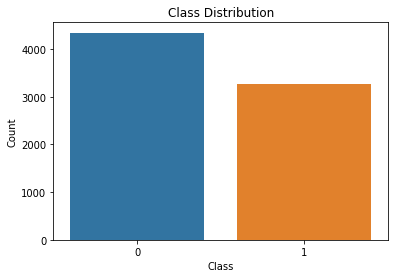

In [8]:
ax = sns.countplot(x = 'target', data = data)
ax.set(xlabel='Class', ylabel='Count', title = 'Class Distribution')
plt.show()

There are more Non-disaster than Disaster tweets 

### Total number of words in each tweet

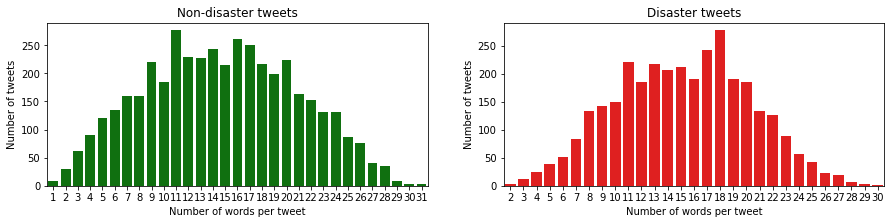

In [0]:
#find length of each tweet in disaster and non disaster
data_len_0 = data[data['target']==0]['text'].str.split().map(lambda x: len(x))
data_len_1 = data[data['target']==1]['text'].str.split().map(lambda x: len(x)) 

fig, axes = plt.subplots(1, 2, figsize=(15,3))

sns.countplot(data_len_0, ax=axes[0], color='green')
axes[0].set(xlabel='Number of words per tweet', ylabel='Number of tweets', title='Non-disaster tweets')

sns.countplot(data_len_1, ax=axes[1], color='red')
axes[1].set(xlabel='Number of words per tweet', ylabel='Number of tweets', title='Disaster tweets')

plt.show()

The distribution for number of words per tweet looks similar between disaster and non-disaster tweets 

### Create training and validation sets

In [0]:
# Create validation set, stratified based on target class distribution
s = StratifiedShuffleSplit(test_size=0.1, random_state=42)

for train_index, val_index in s.split(data, data["target"]): 
    train = data.loc[train_index]
    val = data.loc[val_index]
    
train.reset_index(inplace=True, drop=True) 
val.reset_index(inplace=True, drop=True) 

# Data Cleaning

In [0]:
def clean(text):
    
  #Lowercase the words
  text = text.lower()

  #Expand contractions
  text = re.sub(r"ain't", "am not", text)
  text = re.sub(r"aren't", "are not", text)
  text = re.sub(r"can't", "cannot", text)
  text = re.sub(r"couldn't", "could not", text)
  text = re.sub(r"could've", "could have", text)
  text = re.sub(r"didn't", "did not", text)
  text = re.sub(r"doesn't", "does not", text)
  text = re.sub(r"don't", "do not", text)
  text = re.sub(r"hasn't", "has not", text)
  text = re.sub(r"haven't", "have not", text)
  text = re.sub(r"he'll", "he will", text)
  text = re.sub(r"here's", "here is", text)
  text = re.sub(r"he's", "he is", text)
  text = re.sub(r"i'd", "i would", text)
  text = re.sub(r"i'll", "i will", text)
  text = re.sub(r"i'm", "i am", text)
  text = re.sub(r"isn't", "is not", text)
  text = re.sub(r"it'll", "it will", text)
  text = re.sub(r"it's", "it is", text)
  text = re.sub(r"i've", "i have", text)
  text = re.sub(r"let's", "let us", text)
  text = re.sub(r"shouldn't", "should not", text)
  text = re.sub(r"should've", "should have", text)
  text = re.sub(r"that's", "that is", text)
  text = re.sub(r"there's", "there is", text)
  text = re.sub(r"they'd", "they would", text)
  text = re.sub(r"they'll", "they will", text)
  text = re.sub(r"they're", "they are", text)
  text = re.sub(r"they've", "they have", text)
  text = re.sub(r"wasn't", "was not", text)
  text = re.sub(r"we'd", "we would", text)
  text = re.sub(r"we'll", "we will", text)
  text = re.sub(r"we're", "we are", text)
  text = re.sub(r"weren't", "were not", text)
  text = re.sub(r"we've", "we have", text)
  text = re.sub(r"what's", "what is", text)
  text = re.sub(r"where's", "where is", text)
  text = re.sub(r"who's", "who is", text)
  text = re.sub(r"won't", "will not", text)
  text = re.sub(r"wouldn't", "would not", text)
  text = re.sub(r"would've", "would have", text)
  text = re.sub(r"y'all", "you all", text)
  text = re.sub(r"you'd", "you would", text)
  text = re.sub(r"you'll", "you will", text)
  text = re.sub(r"you're", "you are", text)
  text = re.sub(r"you've", "you have", text)
  
  #Remove URL
  pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') 
  text = pattern.sub('', text)    
  
  #Remove punctuations
  table = str.maketrans('','',string.punctuation)
  text = text.translate(table) 

  #2nd round of cleaning after looking at the list of words which exist in training corpus, but missing in GloVe's dictionary 
  #I cleaned up the most frequent special characters, abbreviations, slang, typos
  text = re.sub(r"mh370", "malaysian airlines flight 370", text)
  text = re.sub(r"x89û_", "", text)
  text = re.sub(r"'the", "the", text)
  text = re.sub(r"16yr", "16 year", text)
  text = re.sub(r"'we", "we", text)
  text = re.sub(r"re\x89û_", "", text)
  text = re.sub(r"prebreak", "pre break", text)
  text = re.sub(r"typhoon-devastated", "typhoon devastated", text)
  text = re.sub(r"'i", "i", text)
  text = re.sub(r"w/", "with", text)
  text = re.sub(r"bestnaijamade", "best naija made", text)
  text = re.sub(r"nowplaying", "now playing", text)
  text = re.sub(r"'conclusively", "conclusively", text)
  text = re.sub(r"\x89ûó", "", text)     
  text = re.sub(r"\x89ûï", "", text)  
  text = re.sub(r"disea", "disease", text)  
  text = re.sub(r"'it", "it", text)  
  text = re.sub(r"gbbo", "great british bake off", text)  
  text = re.sub(r"funtenna", "software hack", text)  
  text = re.sub(r"lmao", "laughing my ass off", text)  
  text = re.sub(r"subreddits", "forum", text)  
  text = re.sub(r"m.o.p", "billy danze", text)  
  text = re.sub(r"utc2015-08-05", "5 august 2015", text)  
  text = re.sub(r"don\x89ûªt", "do not", text)  
  text = re.sub(r"\x89ûïwhen", "when", text)  
  text = re.sub(r"'food", "food", text)  
  text = re.sub(r"arianagrande", "ariana grander", text)  
  text = re.sub(r"yyc", "calgary international airport", text)  
  text = re.sub(r"sensor-senso", "sensor", text)  
  text = re.sub(r"directioners", "fans of one direction band", text)
  text = re.sub(r"sismo", "seismic", text)    
  text = re.sub(r"\x89û\x9d", "", text)    
  text = re.sub(r"time2015-08-06", "time 6 august 2015", text)    
  text = re.sub(r"abstorm", "alberta storm", text)    
  text = re.sub(r"justinbieber", "justin bieber", text)    
  text = re.sub(r"irandeal", "iran deal", text)    
  text = re.sub(r"worldnews", "world news", text)    
  text = re.sub(r"mediterran", "mediterranean sea", text)    
  text = re.sub(r"it\x89ûªs", "it is", text)    
  text = re.sub(r"'avoiding", "avoiding", text)    
  text = re.sub(r"trfc", "traffic", text) #removed asterisks before trfc
  text = re.sub(r"tcot", "top conservatives on twitter", text)    
  text = re.sub(r"okwx", "oklahoma weather", text)    
  text = re.sub(r"you\x89ûªve", "you have", text)    
  text = re.sub(r"53inch", "53 inch", text)    
  text = re.sub(r"300w", "300 watts", text)    
  text = re.sub(r"icemoon", "dj ice moon music", text)    
  text = re.sub(r"djicemoon", "dj ice moon music", text)    
  text = re.sub(r"trapmusic", "trap music", text)    
  text = re.sub(r"ices\x89û_", "ice", text)    
  text = re.sub(r"åê", "", text)    
  text = re.sub(r"o784", "", text)    
  text = re.sub(r"spos", "", text)    
  text = re.sub(r"'save", "save", text)    
  text = re.sub(r"beyhive", "beyonce singer fan", text)    
  text = re.sub(r"mhtw4fnet", "", text)    
  text = re.sub(r"stand-user", "stand user", text)    
  text = re.sub(r"meat-loving", "meat loving", text)    
  text = re.sub(r"freakiest", "freakiest", text)    
  text = re.sub(r"i\x89ûªm", "i am", text)
  text = re.sub(r"\x89û", "", text)
  text = re.sub(r"\x89ûò", "", text)
  text = re.sub(r"re\x89û", "", text)
  text = re.sub(r"typhoondevastated", "typhoon devastated", text)
  text = re.sub(r"11yearold", "11 year old", text)
  text = re.sub(r"diseasese", "disease", text)
  text = re.sub(r"utc20150805", "5 august 2015", text)
  text = re.sub(r"gtgt", "", text)
  text = re.sub(r"time20150806", "6 august 2015", text)
  text = re.sub(r"selfimage", "self image", text)
  text = re.sub(r"china\x89ûªs", "chinas", text)
  text = re.sub(r"ices\x89û", "ices", text)
  text = re.sub(r"read\x89û", "read", text)
  text = re.sub(r"america\x89ûªs", "america", text)

  # Fixing ... and ..
  text = text.replace('...', ' ... ')
  if '...' not in text:
    text = text.replace('..', ' ... ')   
  
  return text

In [0]:
sample_sentence = "Check if punctuations such as !@#$%^&*()_+=-[];'\|~`./,{}:?>< . .. ... & URL such as https://www.kaggle.com/c/nlp-getting-started are removed"
clean(sample_sentence)

'check if punctuations such as      url such as  are removed'

### Clean training set

In [0]:
train_clean = train.copy()
train_clean['text'] = train_clean['text'].apply(lambda series : clean(series))

# Data Preprocessing

### Prepare corpus for training set 

In [0]:
stopNLTK = set(stopwords.words('english')) # stop words from NLTK
stopWORDCLOUD = set(STOPWORDS) # stopwords from WORDCLOUD
stop_words = stopNLTK | stopWORDCLOUD # combine all of the unique stopwords from NLTK and WORDCLOUD

# create a corpus without stop words and non-alphabet-words
def create_corpus(df):
    corpus = []
    for sentence in df['text']:
        #words=[word.lower() for word in word_tokenize(sentence) if (word not in stop_words)] #word_tokenize splits a sentence into individual words
        words=[word.lower() for word in word_tokenize(sentence) if ((word.isalpha()==1) & (word not in stop_words))] #word_tokenize splits a sentence into individual words
        corpus.append(words)
    return corpus # returns a list

In [0]:
train_corpus = create_corpus(train_clean) # prepared a cleaned corpus, which will be tokenized and padded

### Tokenize and pad training set

In [0]:
tokenizer = Tokenizer(num_words = None, oov_token="<OOV>")
tokenizer.fit_on_texts(train_corpus) # tokenize (split the corpus into individual words) and assign an index based on word frequency

train_sequences = tokenizer.texts_to_sequences(train_corpus) # converts each word in each tweet into numbers
seq_len = 32
train_padded = pad_sequences(train_sequences, maxlen = seq_len, truncating='post', padding='post') #makes each sentence the same length by padding, or truncating at the end of the sentence

### Create embedding dictionary from pre-trained GloVe model

In [0]:
# This cell creates the embedding DICT which reads from the glove file that contains 400k unique words and its corresponding vectors 
# When the embedding MATRIX is created later, this dictionary will be referred to get the vectors for the words in training corpus 

embedding_dict = {}

with open('/content/drive/My Drive/Twitter/glove_6B_100d.txt','r', encoding = "utf-8") as g: 
    for line in g: # each 'line' is a string which contains a WORD and its corresponding VECTOR (which contains 100 numbers, because 100 dimensions)
        values = line.split() # .split() will split a 'line' string into a list, in which the first item is the WORD, the next 100 items are the 100 numbers
        word = values[0] # get the WORD
        vector = np.asarray(values[1:], dtype = 'float32') # get the VECTOR
        embedding_dict[word] = vector # in this dictionary, the key is the WORD, the value is the corresponding VECTOR. Appends automatically during for loop

g.close()
embedding_dim = 100

### Create embedding matrix from the embedding dict

In [0]:
word_index = tokenizer.word_index # returns a dictionary of words, ordered based on the word's frequency in training corpus. <OOV> will automatically have an index of 1
vocab_size = len(word_index) + 1 # +1 accounts for the padding value of 0 in each input sequence 
print (f"Vocabulary size = {vocab_size}. It accounts for the 15180 unique words from training corpus AND <OOV> AND the padding value of 0")

Vocabulary size = 15182. It accounts for the 15180 unique words from training corpus AND <OOV> AND the padding value of 0


In [0]:
embedding_matrix = np.zeros((vocab_size, embedding_dim)) 

for word,idx in word_index.items(): #.items() returns the dict's key-value pairs (key = 'word', value = its 'idx'). 
    emb_vec = embedding_dict.get(word, 0) #get the value (ie. vector) of key (ie. word) from GloVe dict. If no such word exist, it returns a 0 vector
    embedding_matrix[idx] = emb_vec # each row (except index 0) represents a word including <OOV>, each column is a dimension. 

### Check for words which exist in training corpus but missing in GloVe's dictionary

After checking for the words, I will perform an additional round of cleaning, then re-run the above preprocessing steps

In [0]:
missing_idx = np.where(~embedding_matrix.any(axis=1))[0] # indices of the words which exist in training corpus but missing in GloVe's dictionary)
missing_list = []

for i in missing_idx:
  for key, value in word_index.items():
      if i == value: 
          missing_list.append(key) #append the missing word

print(f"There are {len(missing_list)} words which exist in training corpus but missing GloVe's dictionary")

There are 4091 words which exist in training corpus but missing GloVe's dictionary


I initially completed this section using set difference like below:
```
a = set(word_index.keys())
b = set(embedding_dict.keys())
missing_list = list(a-b)
```
But the issue was: the words in the set difference were unordered. I want the list of words to be ordered based on word frequency. This helps me in figuring out which words I should be cleaning first.


In [0]:
# print(missing_list) # prints the missing words starting with the most frequent word in the training corpus. 

### Validation set - clean, prepare corpus, tokenize, and pad

In [0]:
def full_transform(df): # will be applied to both validation set and submission set later
    df['text'] = df['text'].apply(lambda c : clean(c))

    df_corpus = create_corpus(df) # prepared the complete text containing proper words, which will then be tokenized and padded

    df_sequences = tokenizer.texts_to_sequences(df_corpus)
    df_padded = pad_sequences(df_sequences, maxlen = seq_len, truncating='post', padding='post')
    
    return df_padded

In [0]:
val_padded = full_transform(val)

# Train Model

In [0]:
X_train = np.array(train_padded)
y_train = np.array(train['target'])
X_val = np.array(val_padded)
y_val = np.array(val['target'])

In [0]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_val:', y_val.shape)

Shape of X_train: (6851, 32)
Shape of X_val: (762, 32)
Shape of y_train: (6851,)
Shape of y_val: (762,)


In [0]:
#Create the model
model = Sequential([
    Embedding(input_dim = vocab_size, 
              output_dim = embedding_dim, #dimensions of dense embedding
              embeddings_initializer = Constant(embedding_matrix), #initialize with GloVe’s word embeddings
              input_length = seq_len, # sequence length 
              trainable = False), 
    Bidirectional(GRU(128, dropout = 0.1, return_sequences=True)),
    Bidirectional(GRU(64, dropout = 0.2, kernel_regularizer=l2(1e-4))),
    Dense(1, activation = 'sigmoid')
])

#model.compile(loss = 'binary_crossentropy', optimizer = SGD(lr=1e-3, momentum = 0.9, nesterov=True), metrics = ['accuracy'])
model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=1e-5), metrics = ['accuracy'])

model.summary()

# Callbacks
checkpoint = ModelCheckpoint("/content/drive/My Drive/Twitter/twitter_model_2",                                                 
                              monitor = 'val_loss',                                                
                              save_best_only=True) # save the model with the lowest val_loss

early_stop = EarlyStopping(monitor = 'val_loss', patience=10)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=1, verbose=1, factor=0.5)

# Train the model
history = model.fit(X_train, #padded sequences
                    y_train, #labels
                    batch_size=128, 
                    epochs=100, 
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks=[checkpoint, early_stop, lr_scheduler])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           1518200   
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 256)           176640    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               123648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,818,617
Trainable params: 300,417
Non-trainable params: 1,518,200
_________________________________________________________________
Epoch 1/100
54/54 - 4s - loss: 0.7212 - accuracy: 0.5849 - val_loss: 0.7143 - val_accuracy: 0.6273 - lr: 1.0000e-05
Epoch 2/100
54/54 - 2s - loss: 0.7029 - accuracy: 0.6650 - val_loss: 0.7005 - val_accuracy: 0.6680 - lr: 1.0000e-05
Epoch 

# Evaluate Model

### Plot loss VS epoch

In [0]:
def plot_graphs(history, metric):
    joblib.dump(history.history[metric], "/content/drive/My Drive/Twitter/train_" + metric + ".pkl") #save training metric
    joblib.dump(history.history['val_' + metric], "/content/drive/My Drive/Twitter/val_" + metric + ".pkl") #save validation metric
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric)

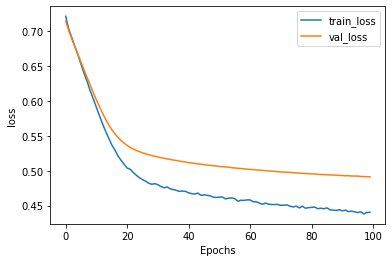

In [0]:
plot_graphs(history, "loss")

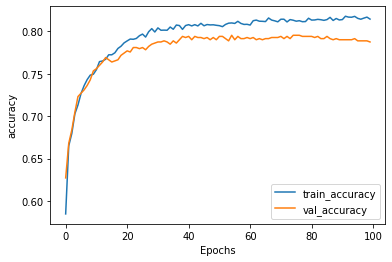

In [0]:
plot_graphs(history, "accuracy")

### Confusion Matrix

In [0]:
y_pred = model.predict (X_val) # outputs class probabilities
y_pred = np.round(y_pred).astype(int).reshape((y_pred.shape[0])) # round probab to either 0 or 1

y_true = y_val.reshape((y_val.shape[0])) 

conf = confusion_matrix (y_true, y_pred) 
conf

array([[375,  60],
       [102, 225]])

In [0]:
TP = conf[1,1] # true positives
TN = conf[0,0] # true negatives
FP = conf[0,1] # false positives
FN = conf[1,0] # false negatives

print(f"The model incorrectly classified {FP/(TN+FP)*100:.0f}% of {val['target'].shape[0] - val['target'].sum()} non-disaster tweets and {FN/(FN+TP)*100:.0f}% of {val['target'].sum()} disaster tweets")
print(f"Precision: {TP/(TP+FP):.2f}") # precision = TP/TP+FP
print(f"Recall: {TP/(TP+FN):.2f}") # recall = TP/TP+FN
print(f"F1 score: {2/(1/(TP/(TP+FP)) + 1/(TP/(TP+FN))):.2f}") #f1 score = 2/(1/precision  +   1/recall)

The model incorrectly classified 14% of 435 non-disaster tweets and 31% of 327 disaster tweets
Precision: 0.79
Recall: 0.69
F1 score: 0.74


### Writing the misclassified tweets to CSV file to perform error analysis

In [0]:
# These setting below allow me to view the entire tweet
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', 1000000)

In [0]:
df = val[y_pred != y_true].reset_index(drop=True) # raw version of the tweets which were inaccurately classified

x_clean_wrong = tokenizer.sequences_to_texts(X_val[y_pred != y_true]) # get the cleaned tweets which were inaccurately classified
df.insert(1,'Clean Text', x_clean_wrong) #insert the column (labelled as 'Clean Text') into df

df = df.rename(columns = {'text':'Raw Text', 'target': 'Supposed to be'})

df.to_csv('/content/drive/My Drive/Twitter/error_analysis.csv', index = False)

# Submission

In [0]:
model = load_model('/content/drive/My Drive/Twitter/twitter_model_2') 

In [0]:
submission = pd.read_csv('/content/drive/My Drive/Twitter/test.csv')

submit_id = submission['id']
submission.drop(['id','keyword','location'], axis=1, inplace = True) 

submission_padded = full_transform(submission)

In [0]:
y_pred = model.predict (submission_padded) # class probabilities
y_pred = np.round(y_pred).astype(int).reshape((y_pred.shape[0])) # round to 0 to 1

In [0]:
df = pd.DataFrame({'id': submit_id, 'target': y_pred})
df.to_csv('/content/drive/My Drive/Twitter/twitter_submission_2.csv', index = False)